# <b style='color:blue;'> Random Forest </b>

* Este Jupyter tem como função treinar um `Random Forest` com os melhores parametros determinados por um `RandomSearch`.

-> Dataset completo com voluntários femininos e masculinos, sem outliers e sem a coluna de semanas.

---

Bibliotecas/Módulos

In [1]:
import logging
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pickle as pkl
import seaborn as sns
import sys

from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score, accuracy_score, matthews_corrcoef, classification_report, f1_score, confusion_matrix
from sklearn.model_selection import RandomizedSearchCV, train_test_split

Configurações dos logs

In [2]:
logger = logging.getLogger("SVM")
logger.setLevel(logging.DEBUG)
handler = logging.StreamHandler(sys.stderr)
formatter = logging.Formatter('%(name)s - %(levelname)s - [+] ------- %(message)s -------') 
handler.setFormatter(formatter)
logger.handlers = [handler]

Cores

In [3]:
RED = "\033[1;31m"
BLUE = "\033[1;34m"
GREEN = "\033[1;32m"
PINK = "\033[1;45m"
HEADER = '\033[95m'
OKBLUE = '\033[94m'
OKCYAN = '\033[96m'
OKGREEN = '\033[92m'
WARNING = '\033[93m'
FAIL = '\033[91m'
ENDC = '\033[0m'
BOLD = '\033[1m'
UNDERLINE = '\033[4m'
MAG = "\033[1;45m"

---

## Preparando os dados

In [4]:
df = pd.read_csv("dados_FEM_MAS_10_voluntarios_s_semanas_15_sinais_noout.csv")

In [5]:
df.sample()

,0,1,2,3,4,5,6,7,8,9,...,1991,1992,1993,1994,1995,1996,1997,1998,1999,label
15260,-3,-4,-4,-3,-4,-4,-4,-3,-4,-3,...,-4,-4,-4,-3,-4,-3,-3,-2,-3,1


Verificando tamanho do dataset

In [6]:
len(df)

25200

Verificando a quantidade de colunas originais

In [7]:
len(df.columns)

2001

* Seleção da variável target e das features

In [8]:
y = df["label"]

In [9]:
df = df.drop(["label"], axis=1)

#### PCA
Aplicando o PCA para reduzir a dimensão dos dados.

In [10]:
pca = PCA(n_components=1000)

In [11]:
pca.fit(df)

PCA(n_components=1000)

In [12]:
%%time

pca_samples = pca.transform(df)

CPU times: user 25.1 s, sys: 7.72 s, total: 32.9 s
Wall time: 2.56 s


In [13]:
ps = pd.DataFrame(pca_samples)
ps.head()

,0,1,2,3,4,5,6,7,8,9,...,990,991,992,993,994,995,996,997,998,999
0,-35.068197,23.928768,1.186254,-151.129527,-42.556784,-148.023683,-53.831397,-28.461750,-41.857889,-104.510884,...,-10.594954,-9.102758,31.217962,7.598475,-26.955279,-18.582418,1.897785,42.778355,53.829143,5.098217
1,-69.680457,36.845880,47.351802,-121.842658,-24.717552,-113.801059,-37.514149,-47.755131,-13.947044,-92.122796,...,-4.492789,-11.990844,13.351993,20.945349,-35.418797,-0.784969,5.506354,32.152800,36.256651,24.391820
2,-94.676600,38.038653,98.432548,-103.621516,-10.274245,-71.540178,-15.104704,-53.717266,24.066586,-97.600882,...,17.981009,-10.248796,9.297715,33.874125,-35.531096,15.711742,-5.553752,25.474395,30.571692,21.154016
3,-115.288910,36.334428,137.247898,-70.874058,-8.118221,-44.962368,-3.156064,-64.584880,46.295866,-89.627326,...,28.774838,-14.861625,-10.039766,47.899447,-20.979064,16.955070,-7.998481,20.736931,28.519497,21.540073
4,-111.539509,45.575378,158.235942,-48.798876,-3.696119,-8.481742,11.270159,-71.759108,48.659401,-69.601917,...,57.076598,-26.563836,-12.359871,60.574898,-18.495129,14.230669,-22.055194,19.326159,28.652353,28.643327


In [14]:
len(ps)

25200

In [15]:
len(ps.columns)

1000

In [16]:
X = ps

Separando os dados em dados de treino e teste

In [17]:
x_treino, x_teste, y_treino, y_teste = train_test_split(X, y, test_size=0.2, random_state=7)

---

## Treinamento

### RandomSeach

Parametros do modelo escolhidos para otimização

In [18]:
values = {'criterion': ["gini", "entropy", "log_loss"], "max_features": ["sqrt", "log2", None]}

In [19]:
clf = RandomForestClassifier()

In [20]:
def best_params(values: dict, clf: 'classificador', x_treino: np.array, x_teste: np.array, y_treino: np.array, y_teste: np.array) -> list:
    '''
        Instancia um classificador de busca e procura os melhores parâmetros para o modelo.
        
        Params
        ------
        :values: parametros a serem testados
        :clf: instancia do classificador desejado
        :x_treino: dados de treino
        :x_teste: dados de teste
        :y_treino: dados de treino -labels
        :y_teste: dados de treino - labels
        
        Return
        ------
        :best_params: lista com os melhores parametros
    '''
    
    logger.info('Instanciando RF')
    random_clf = RandomizedSearchCV(clf, param_distributions=values, n_iter=200)
    
    logger.info('Treinando RF')
    random_clf.fit(x_treino, y_treino)
  
    logger.info('Parametros RF')
    print(RED, random_clf.get_params())
    
    logger.info('Best Params RF')
    best_params = random_clf.best_params_
    print(BLUE, best_params)
    
    return best_params

In [ ]:
%%time

try:
    logging.info("teste")
    best = best_params(values, clf, x_treino, x_teste, y_treino, y_teste)

except Exception as error:
    logger.warning('Aconteceu algum problema...')
    logger.critical(error)

else:
    logger.info('Ok')
    
finally:
    logger.info('Busca finalizada')

SVM - INFO - [+] ------- Instanciando RF -------
INFO:SVM:Instanciando RF
SVM - INFO - [+] ------- Treinando RF -------
INFO:SVM:Treinando RF
/home/saraselis/.local/lib/python3.8/site-packages/sklearn/model_selection/_search.py:306: UserWarning: The total space of parameters 9 is smaller than n_iter=200. Running 9 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


Melhores parâmetros:

{'n_jobs': 1, 'n_estimators': 100, 'min_samples_leaf': 1}

In [ ]:
best

----

### Random Forest

Treinando o modelo com os melhore parametros

In [18]:
def classificador(x_treino: np.array, y_treino: np.array, x_teste: np.array, y_teste: np.array):
    '''
        Treina um classificador com os melhores parametros possíveis.
        
        Params
        ------
        :x_treino: dados de treino
        :x_teste: dados de teste
        :y_treino: dados de treino -labels
        :y_teste: dados de treino - labels
    
        Return
        ------
        :RF: Modelo Random Forest treinado
        :resultados (matrix): métricas
    '''
    
    logger.info('Instanciando Random Forest')
    RF = RandomForestClassifier(n_jobs= 1, n_estimators= 100, min_samples_leaf= 1)
    
    logger.info('Treinando Random Forest')
    RF.fit(x_treino, y_treino)
    
    logger.info('Predict')
    p = RF.predict_proba(x_teste)[:, 1]
    categorias = RF.predict(x_teste)
    
    print('Métricas: \n \n')
    
    logger.info('Roc')
    roc = roc_auc_score(y_teste, categorias)
    print(OKBLUE, "Roc \n" + str(roc) + "\n")
    
    logger.info('Acurácia')
    acc = accuracy_score(y_teste, categorias)
    print(OKCYAN, "Acc \n" + str(acc) + "\n")
    
    logger.info("Mcc")
    mcc = matthews_corrcoef(y_teste, categorias)
    print(WARNING, "Mcc \n" + str(mcc) + "\n")
    
    logger.info("F1")
    f1 = f1_score(y_teste, categorias)
    print(GREEN, "F1 \n" + str(f1) + "\n")
    
    logger.info('Class Report')
    resultados = classification_report(y_teste, categorias)
    print(ENDC, "Class Report \n" + resultados + "\n")
    
    mat = confusion_matrix(y_teste, categorias)
    sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False)
    plt.xlabel('true label')
    plt.ylabel('predicted label');

    return RF, resultados

SVM - INFO - [+] ------- Instanciando Random Forest -------
SVM - INFO - [+] ------- Treinando Random Forest -------
SVM - INFO - [+] ------- Predict -------
SVM - INFO - [+] ------- Roc -------
SVM - INFO - [+] ------- Acurácia -------
SVM - INFO - [+] ------- Mcc -------
SVM - INFO - [+] ------- F1 -------
SVM - INFO - [+] ------- Class Report -------
SVM - INFO - [+] ------- Ok -------
SVM - INFO - [+] ------- Treino finalizado -------


Métricas: 
 

 Roc 
0.7837432500272424

 Acc 
0.7837301587301587

 Mcc 
0.5677869961612135

 F1 
0.780241935483871

 Class Report 
              precision    recall  f1-score   support

           0       0.77      0.80      0.79      2518
           1       0.79      0.77      0.78      2522

    accuracy                           0.78      5040
   macro avg       0.78      0.78      0.78      5040
weighted avg       0.78      0.78      0.78      5040


CPU times: user 1min 41s, sys: 0 ns, total: 1min 41s
Wall time: 1min 41s


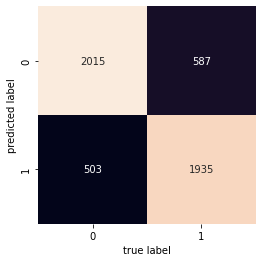

In [19]:
%%time

try:
    RF, resultados = classificador(
                        x_treino,
                        y_treino,
                        x_teste,
                        y_teste)

except Exception as error:
    logger.warning('Aconteceu algum problema...')
    logger.critical(error)

else:
    logger.info('Ok')
    
finally:
    logger.info('Treino finalizado')

----

#### Exportando modelo

In [21]:
pkl.dump(RF, open('modelos/rf_dados_FEM_MAS_10_voluntarios_s_semanas_15_sinais_noout.pkl', 'wb'))